In [19]:
#######################################################################
# Copyright (C)                                                       #
# 2016 - 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)           #
# 2016 Jan Hakenberg(jan.hakenberg@gmail.com)                         #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import pickle

BOARD_ROWS = 3
BOARD_COLS = 3
BOARD_SIZE = BOARD_ROWS * BOARD_COLS

class State:
    def __init__(self):
        # the board is represented by an n * n array,
        # 1 represents a chessman of the player who moves first,
        # -1 represents a chessman of another player
        # 0 represents an empty position
        self.data = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.winner = None
        self.hash_val = None
        self.end = None

    # compute the hash value for one state, it's unique
    def hash(self):
        if self.hash_val is None:
            self.hash_val = 0
            for i in self.data.reshape(BOARD_ROWS * BOARD_COLS):
                if i == -1:
                    i = 2
                self.hash_val = self.hash_val * 3 + i
        return int(self.hash_val)

    # check whether a player has won the game, or it's a tie
    def is_end(self):
        if self.end is not None:
            return self.end
        results = []
        # check row
        for i in range(0, BOARD_ROWS):
            results.append(np.sum(self.data[i, :]))
        # check columns
        for i in range(0, BOARD_COLS):
            results.append(np.sum(self.data[:, i]))

        # check diagonals
        results.append(0)
        for i in range(0, BOARD_ROWS):
            results[-1] += self.data[i, i]
        results.append(0)
        for i in range(0, BOARD_ROWS):
            results[-1] += self.data[i, BOARD_ROWS - 1 - i]

        for result in results:
            if result == 3:
                self.winner = 1
                self.end = True
                return self.end
            if result == -3:
                self.winner = -1
                self.end = True
                return self.end

        # whether it's a tie
        sum = np.sum(np.abs(self.data))
        if sum == BOARD_ROWS * BOARD_COLS:
            self.winner = 0
            self.end = True
            return self.end

        # game is still going on
        self.end = False
        return self.end

    # @symbol: 1 or -1
    # put chessman symbol in position (i, j)
    def next_state(self, i, j, symbol):
        new_state = State()
        new_state.data = np.copy(self.data)
        new_state.data[i, j] = symbol
        return new_state

    # print the board
    def print_state(self):
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.data[i, j] == 1:
                    token = '*'
                if self.data[i, j] == 0:
                    token = '0'
                if self.data[i, j] == -1:
                    token = 'x'
                out += token + ' | '
            print(out)
        print('-------------')

def get_all_states_impl(current_state, current_symbol, all_states):
    for i in range(0, BOARD_ROWS):
        for j in range(0, BOARD_COLS):
            if current_state.data[i][j] == 0:
                newState = current_state.next_state(i, j, current_symbol)
                newHash = newState.hash()
                if newHash not in all_states.keys():
                    isEnd = newState.is_end()
                    all_states[newHash] = (newState, isEnd)
                    if not isEnd:
                        get_all_states_impl(newState, -current_symbol, all_states)

def get_all_states():
    current_symbol = 1
    current_state = State()
    all_states = dict()
    all_states[current_state.hash()] = (current_state, current_state.is_end())
    get_all_states_impl(current_state, current_symbol, all_states)
    return all_states

# all possible board configurations
all_states = get_all_states()

class Judger:
    # @player1: the player who will move first, its chessman will be 1
    # @player2: another player with a chessman -1
    def __init__(self, player1, player2):
        self.p1 = player1
        self.p2 = player2
        self.current_player = None
        self.p1_symbol = 1
        self.p2_symbol = -1
        self.p1.set_symbol(self.p1_symbol)
        self.p2.set_symbol(self.p2_symbol)
        self.current_state = State()

    def reset(self):
        self.p1.reset()
        self.p2.reset()

    def alternate(self):
        while True:
            yield self.p1
            yield self.p2

    # @print_state: if True, print each board during the game
    def play(self, print_state=False):
        alternator = self.alternate()
        self.reset()
        current_state = State()
        self.p1.set_state(current_state)
        self.p2.set_state(current_state)
        while True:
            player = next(alternator)
            if print_state:
                current_state.print_state()
            [i, j, symbol] = player.act()
            next_state_hash = current_state.next_state(i, j, symbol).hash()
            current_state, is_end = all_states[next_state_hash]
            self.p1.set_state(current_state)
            self.p2.set_state(current_state)
            if is_end:
                if print_state:
                    current_state.print_state()
                return current_state.winner

# AI player
class Player:
    # @step_size: the step size to update estimations
    # @epsilon: the probability to explore
    def __init__(self, step_size=0.1, epsilon=0.1):
        self.estimations = dict()
        self.step_size = step_size
        self.epsilon = epsilon
        self.states = []
        self.greedy = []

    def reset(self):
        self.states = []
        self.greedy = []

    def set_state(self, state):
        self.states.append(state)
        self.greedy.append(True)

    def set_symbol(self, symbol):
        self.symbol = symbol
        for hash_val in all_states.keys():
            (state, is_end) = all_states[hash_val]
            if is_end:
                if state.winner == self.symbol:
                    self.estimations[hash_val] = 1.0
                elif state.winner == 0:
                    # we need to distinguish between a tie and a lose
                    self.estimations[hash_val] = 0.5
                else:
                    self.estimations[hash_val] = 0
            else:
                self.estimations[hash_val] = 0.5

    # update value estimation
    def backup(self):
        for debug
        print('player trajectory')
        for state in self.states:
            state.print_state()

        self.states = [state.hash() for state in self.states]

        for i in reversed(range(len(self.states) - 1)):
            state = self.states[i]
            td_error = self.greedy[i] * (self.estimations[self.states[i + 1]] - self.estimations[state])
#             td_error = self.estimations[self.states[i + 1]] - self.estimations[state]
            self.estimations[state] += self.step_size * td_error

    # choose an action based on the state
    def act(self):
        state = self.states[-1]
        next_states = []
        next_positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if state.data[i, j] == 0:
                    next_positions.append([i, j])
                    next_states.append(state.next_state(i, j, self.symbol).hash())

        if np.random.rand() < self.epsilon:
            action = next_positions[np.random.randint(len(next_positions))]
            action.append(self.symbol)
            self.greedy[-1] = False
            return action

        values = []
        for hash, pos in zip(next_states, next_positions):
            values.append((self.estimations[hash], pos))
        # to select one of the actions of equal value at random
        np.random.shuffle(values)
        values.sort(key=lambda x: x[0], reverse=True)
        action = values[0][1]
        action.append(self.symbol)
        return action

    def save_policy(self):
        with open('policy_%s.bin' % ('first' if self.symbol == 1 else 'second'), 'wb') as f:
            pickle.dump(self.estimations, f)

    def load_policy(self):
        with open('policy_%s.bin' % ('first' if self.symbol == 1 else 'second'), 'rb') as f:
            self.estimations = pickle.load(f)

# human interface
# input a number to put a chessman
# | q | w | e |
# | a | s | d |
# | z | x | c |
class HumanPlayer:
    def __init__(self, **kwargs):
        self.symbol = None
        self.keys = ['q', 'w', 'e', 'a', 's', 'd', 'z', 'x', 'c']
        self.state = None
        return

    def reset(self):
        return

    def set_state(self, state):
        self.state = state

    def set_symbol(self, symbol):
        self.symbol = symbol
        return

    def backup(self, _):
        return

    def act(self):
        self.state.print_state()
        key = input("Input your position:")
        data = self.keys.index(key)
        i = data // int(BOARD_COLS)
        j = data % BOARD_COLS
        return (i, j, self.symbol)

def train(epochs, print_every_n=500, p1Eps = .01, p2Eps = .01):
    log = []
    player1 = Player(epsilon=p1Eps)
    player2 = Player(epsilon=p2Eps)
    judger = Judger(player1, player2)
    player1_win = 0.0
    player2_win = 0.0
    for i in range(1, epochs + 1):
        winner = judger.play(print_state=False)
        if winner == 1:
            player1_win += 1
        if winner == -1:
            player2_win += 1
        if i % print_every_n == 0:
#             print('Epoch %d, player 1 winrate: %.02f, player 2 winrate: %.02f' % (i, player1_win / i, player2_win / i))
            log.append((i, player1_win / i, player2_win / i))
        player1.backup()
        player2.backup()
        judger.reset()
    player1.save_policy()
    player2.save_policy()
    return log

def compete(turns, p1Eps = 0, p2Eps = 0):
    log = []
    player1 = Player(epsilon=p1Eps)
    player2 = Player(epsilon=p2Eps)
    judger = Judger(player1, player2)
    player1.load_policy()
    player2.load_policy()
    player1_win = 0.0
    player2_win = 0.0
    for _ in range(0, turns):
        winner = judger.play()
        if winner == 1:
            player1_win += 1
        if winner == -1:
            player2_win += 1
        judger.reset()
    print('%d turns, player 1 win %.02f, player 2 win %.02f' % (turns, player1_win / turns, player2_win / turns))

# The game is a zero sum game. If both players are playing with an optimal strategy, every game will end in a tie.
# So we test whether the AI can guarantee at least a tie if it goes second.
def play():
    while True:
        player1 = HumanPlayer()
        player2 = Player(epsilon=0)
        judger = Judger(player1, player2)
        player2.load_policy()
        winner = judger.play()
        if winner == player2.symbol:
            print("You lose!")
        elif winner == player1.symbol:
            print("You win!")
        else:
            print("It is a tie!")

# if __name__ == '__main__':
#     train(int(1e5))
#     compete(int(1e3))
#     play()



SyntaxError: invalid syntax (<ipython-input-19-25d3cfac925d>, line 206)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
%%time

bothNonGreedy = train(int(1e5), p1Eps=0, p2Eps=0)

CPU times: user 1min 13s, sys: 578 ms, total: 1min 13s
Wall time: 1min 13s


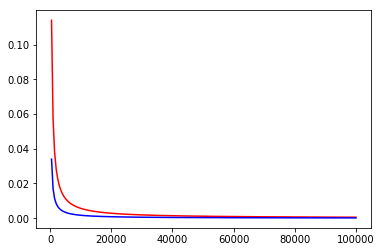

In [17]:
result = bothNonGreedy

time  = list(map(lambda x: x[0], result))
p1 = list(map(lambda x: x[1], result))
p2 = list(map(lambda x: x[2], result))

plt.plot(time, p1, 'r')
plt.plot(time, p2, 'b')

In [18]:
%%time

bothDefault = train(int(1e5))

CPU times: user 1min 4s, sys: 393 ms, total: 1min 4s
Wall time: 1min 4s


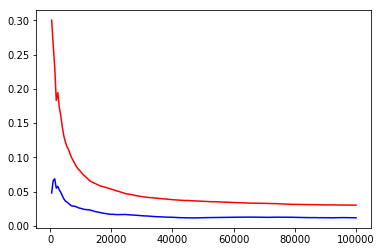

In [16]:
result = bothDefault

time  = list(map(lambda x: x[0], result))
p1 = list(map(lambda x: x[1], result))
p2 = list(map(lambda x: x[2], result))

plt.plot(time, p1, 'r')
plt.plot(time, p2, 'b')

In [20]:
%%time

both10Perc = train(int(1e5), p1Eps=.1, p2Eps=.1)

CPU times: user 1min 4s, sys: 435 ms, total: 1min 4s
Wall time: 1min 4s


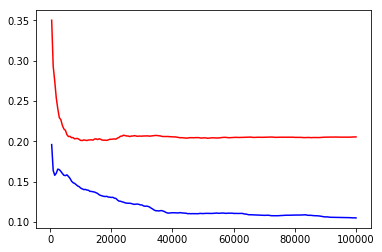

In [21]:
result = both10Perc

time  = list(map(lambda x: x[0], result))
p1 = list(map(lambda x: x[1], result))
p2 = list(map(lambda x: x[2], result))

plt.plot(time, p1, 'r')
plt.plot(time, p2, 'b')

In [2]:
%%time

bothNonGreedy = train(int(1e5), p1Eps=1, p2Eps=1)

CPU times: user 58.3 s, sys: 376 ms, total: 58.7 s
Wall time: 57.8 s


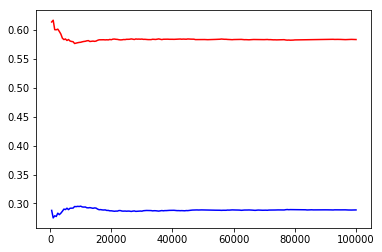

In [8]:
result = bothNonGreedy

time, p1, p2 = zip(*result)

plt.plot(time, p1, 'r')
plt.plot(time, p2, 'b')

In [20]:
%%time

NonGreedyVsGreedy = train(int(1e5), p1Eps=1, p2Eps=0)

CPU times: user 56.8 s, sys: 567 ms, total: 57.4 s
Wall time: 56.3 s


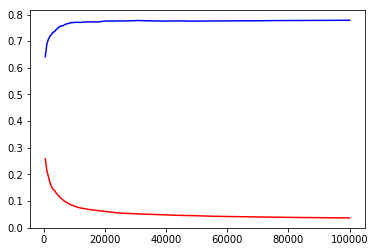

In [18]:
result = NonGreedyVsGreedy

time, p1, p2 = zip(*result)

plt.plot(time, p1, 'r')
plt.plot(time, p2, 'b')